In [1]:
import numpy as np
import matplotlib.pyplot as plt
from openmolecularsystems.systems import TwoLJParticles
from openmolecularsystems.tools.md import langevin_NVT
import simtk.unit as unit
import molsysmt as msm

# La termodinámica del proceso asociación-disociación de dos partículas LJ

In [14]:
osystem = TwoLJParticles(atom_1='Dummy_A', atom_2='Dummy_B',
                         box=[[5.0, 0.0, 0.0], [0.0, 5.0, 0.0], [0.0, 0.0, 5.0]]*unit.nanometers)

In [15]:
osystem.parameters

{'mass_1': Quantity(value=40.0, unit=dalton),
 'sigma_1': Quantity(value=2.0, unit=angstrom),
 'epsilon_1': Quantity(value=2.0, unit=kilocalorie/mole),
 'mass_2': Quantity(value=120.0, unit=dalton),
 'sigma_2': Quantity(value=4.0, unit=angstrom),
 'epsilon_2': Quantity(value=4.5, unit=kilocalorie/mole),
 'box': Quantity(value=[[5.0, 0.0, 0.0], [0.0, 5.0, 0.0], [0.0, 0.0, 5.0]], unit=nanometer),
 'cutoff_distance': Quantity(value=12.0, unit=angstrom),
 'switching_distance': Quantity(value=9.0, unit=angstrom)}

In [16]:
initial_coordinates = np.zeros([2,3])*unit.nanometers
initial_coordinates[0,:] = 1.0*unit.nanometers
initial_coordinates[1,:] = 2.0*unit.nanometers

traj_dict = langevin_NVT(osystem, time=50.0*unit.nanoseconds, saving_timestep=1.0*unit.picoseconds,
                          integration_timestep=5.0*unit.femtoseconds, friction=5.0/unit.picoseconds,
                          temperature=300.0*unit.kelvin, initial_coordinates=initial_coordinates)

100%|█████████▉| 9999900/9999999 [05:00<00:00, 33323.06it/s]


Tomemos la distancia entre los dos átomos como coordenada de reacción y construyamos, con los datos de la trayectoria, el paisaje de energía libre sobre esa coordenada de reacción:

In [17]:
distance = msm.distance(traj_dict, selection=0, selection_2=1, pbc=True)

In [18]:
def occupation_probability_density_1d(traj_x, x_range, n_bins):
    delta_x = (x_range[1]-x_range[0])/n_bins
    frequency = np.zeros(n_bins, dtype=int)
    for x in traj_x:
        bin_visited = int((x-x_range[0])/delta_x)
        frequency[bin_visited]+=1
    x_bins_centers = (x_range[0]+0.5*delta_x) + delta_x*np.arange(n_bins)
    bins_probability_density = (1.0/delta_x)*(frequency/frequency.sum())
    return x_bins_centers, bins_probability_density

In [20]:
x_center_bin, px = occupation_probability_density_1d(distance[:,0,0],
                                                     [0.0,5.0]*unit.nanometers, 200)

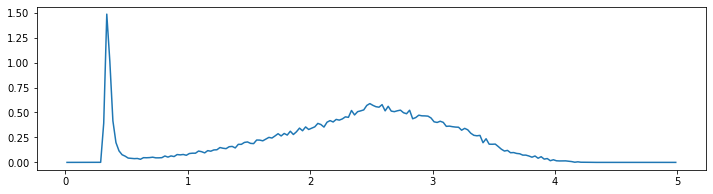

In [21]:
plt.figure(figsize=[12,3])
plt.plot(x_center_bin, px)
plt.show()

In [22]:
KbT = KbT = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA * 300.0*unit.kelvin
Fx_traj = -KbT*np.log(px)

/home/diego/Myopt/miniconda3/envs/UIBCDF-Academia/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


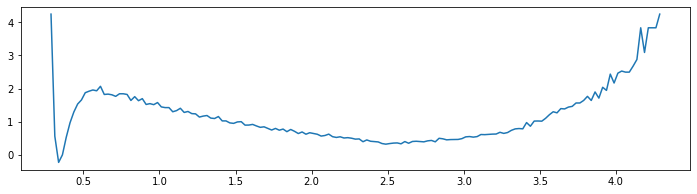

In [23]:
plt.figure(figsize=[12,3])
plt.plot(x_center_bin, Fx_traj.in_units_of(unit.kilocalories_per_mole))
plt.show()

Y ahora de manera teórica:

\begin{equation}
P(d) = \frac{1}{Z_{V}} \iiint_{0.0}^{5.0} \iiint_{0.0}^{5.0} e^{-\frac{1}{K_{B}T}V(d)} \delta(d−dist_{PBC}(x_{A}, y_{A}, z_{A}, x_{B}, y_{B}, z_{B})) \; dx_{A} dy_{A} dz_{A} dx_{B} dy_{B} dz_{B}
\end{equation}

Donde:

\begin{equation}
Z_{V} = \iiint_{0.0}^{5.0} \iiint_{0.0}^{5.0} e^{-\frac{1}{K_{B}T}V(dist_{PBC}(x_{A}, y_{A}, z_{A}, x_{B}, y_{B}, z_{B}))} \; dx_{A} dy_{A} dz_{A} dx_{B} dy_{B} dz_{B}
\end{equation}

\begin{equation}
V(x) = 4 \epsilon_{red} \left[ \left( \frac{x}{\sigma_{red}} \right)^{12} - \left( \frac{x}{\sigma_{red}} \right)^{6} \right]
\end{equation}

\begin{equation}
\sigma_{red} = \frac{1}{2}(\sigma_{A} + \sigma_{B})
\end{equation}

\begin{equation}
\epsilon_{red} = \sqrt{(\epsilon_{A}\epsilon_{B})}
\end{equation}


\begin{equation}
dist_{PBC}(x_{A}, y_{A}, z_{A}, x_{B}, y_{B}, z_{B}) = \sqrt{\theta(x_{A},x_{B})^2+\theta(y_{A},y_{B})^2+\theta(z_{A},z_{B})^2}
\end{equation}